# Load and Test Model for test set 

This notebook loads the model and performs predictions on all the data in the Test set (the split with the least data samples). Once the predictions are completed, a classification plot and confusion matrix is displayed.

## Load dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from tqdm import tqdm
import sys
import av
import pandas as pd
import os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Init file paths and dataframes

In [2]:
data_dir = "dataset"
test_dir = f'../{data_dir}/test'

In [3]:
# All labels
filtered_data = "data"
test_label_df = pd.read_csv(f'../{filtered_data}/test.csv', header=None)

# convert all into hashmap - key = u_vid_name , value = label
test_label = {f"{test_dir}/{k[0]}": k[1] for k in test_label_df.values.tolist()}

In [4]:
# Total label + turkish to english translation
total_label = pd.read_csv(f'../{filtered_data}/filtered_ClassId.csv')
u_len_label = len(total_label['ClassId'].unique())
print("total unique label:", u_len_label)

total unique label: 10


In [5]:
class_id_to_label = {k[0]: k[2] for k in total_label.values.tolist()}

In [6]:
print(class_id_to_label)

{0: 'champion', 1: 'glass', 2: 'wrong', 3: 'bad', 4: 'married', 5: 'potato', 6: 'congratulations', 7: 'child', 8: 'inform', 9: 'father'}


## Load and process video

In [7]:
def extract_frames(vid_path, frames_cap, transforms=None):
    """Extract and transform video frames

    Parameters:
    vid_path (str): path to video file
    frames_cap (int): number of frames to extract, evenly spaced
    transforms (torchvision.transforms, optional): transformations to apply to frame

    Returns:
    list of numpy.array: vid_arr

    """
    vid_arr = []
    with av.open(vid_path) as container:
        stream = container.streams.video[0]
        n_frames = stream.frames
        remainder = n_frames % frames_cap
        interval = n_frames // frames_cap
        take_frame_idx = 0
        for frame_no, frame in enumerate(container.decode(stream)):
            if frame_no == take_frame_idx:
                img = frame.to_image()
                if transforms:
                    img = transforms(img)
                vid_arr.append(np.array(img))
                if remainder > 0:
                    take_frame_idx += 1
                    remainder -= 1
                take_frame_idx += interval
    if len(vid_arr) < frames_cap:
        raise ValueError(f"video with path '{vid_path}' is too short, please make sure that video has >={frames_cap} frames")
    return vid_arr

## Load and test model

In [8]:
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [9]:
from dev_model.models import CNN_LSTM
model = CNN_LSTM(10, 
                 latent_size=512, 
                 n_cnn_layers=6, 
                 n_rnn_layers=1, 
                 n_rnn_hidden_dim=512, 
                 cnn_bn=True, 
                 bidirectional=True, 
                 dropout_rate=0.8,
                 device="cpu",
                 attention=True)
checkpoint = torch.load("../../models/8-checkpoint.pt", map_location=torch.device("cpu"))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

CNN_LSTM(
  (encoder): CNN_Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layers): Sequential(
      (0): ConvBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (a_fn): ReLU()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (batchnorm2): BatchNorm2d(128, 

In [10]:
def load_and_test_video(vid_name):
    """Load video from dataset and pass video to model

    Parameters:
    vid_name (str): video name to display

    """
    transforms_compose = transforms.Compose([transforms.Resize(256), 
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5], std=[0.5])])
    vid_color_path = f"{test_dir}/{vid_name}_color.mp4"
    rgb_arr = extract_frames(vid_color_path, 30, transforms=transforms_compose)
    vid_arr = np.array(rgb_arr)
    vid_arr = vid_arr/255
    vid_arr = torch.from_numpy(vid_arr).float()
    vid_arr = vid_arr.unsqueeze(0)
    predict_id = model.forward(vid_arr)
    predict_id = torch.max(predict_id, 1)[1].item()
    ground_truth_id = test_label[f"{test_dir}/{vid_name}"]
    return predict_id, class_id_to_label[predict_id], ground_truth_id, class_id_to_label[ground_truth_id]

In [11]:
# Load the test set and perform predictions on each sample. Add their ground truths and predictions to lists
df = pd.read_csv("../data/test.csv", names=["video_name", "class_id"])
predict_ids = []
predict_labels = []
ground_truth_ids = []
ground_truth_labels = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    predict_id, predict_label, ground_truth_id, ground_truth_label = load_and_test_video(row['video_name'])
    predict_ids.append(predict_id)
    predict_labels.append(predict_label)
    ground_truth_ids.append(ground_truth_id)
    ground_truth_labels.append(ground_truth_label)

df['predict_id'] = predict_ids
df['predict_label'] = predict_labels
df['ground_truth_id'] = ground_truth_ids
df['ground_truth_label'] = ground_truth_labels

100%|████████████████████████████████████████████████████████████████████████████████| 164/164 [02:57<00:00,  1.08s/it]


In [12]:
df

,video_name,class_id,predict_id,predict_label,ground_truth_id,ground_truth_label
0,signer34_sample4,0,0,champion,0,champion
1,signer34_sample43,2,2,wrong,2,wrong
2,signer34_sample130,8,0,champion,8,inform
3,signer34_sample145,4,4,married,4,married
4,signer34_sample170,7,3,bad,7,child
...,...,...,...,...,...,...
159,signer30_sample575,3,6,congratulations,3,bad
160,signer30_sample576,4,5,potato,4,married
161,signer30_sample588,6,5,potato,6,congratulations
162,signer30_sample617,6,5,potato,6,congratulations


## Analysis of results

- Table of a classification report that details precision, recall, f1-score per class and accuracy
- Confusion matrix of ground truth labels and predictions

In [13]:
target_names = [class_id_to_label[key] if key in class_id_to_label.keys() else 0 for key in range(10)]
print(classification_report(ground_truth_ids, predict_ids, target_names=target_names))

                 precision    recall  f1-score   support

       champion       0.15      0.12      0.13        17
          glass       0.17      0.06      0.09        16
          wrong       0.31      0.24      0.27        17
            bad       0.25      0.24      0.24        17
        married       0.44      0.50      0.47        16
         potato       0.09      0.18      0.12        17
congratulations       0.00      0.00      0.00        14
          child       0.19      0.59      0.29        17
         inform       0.50      0.12      0.19        17
         father       0.50      0.12      0.20        16

       accuracy                           0.22       164
      macro avg       0.26      0.22      0.20       164
   weighted avg       0.26      0.22      0.20       164



Total test data:164


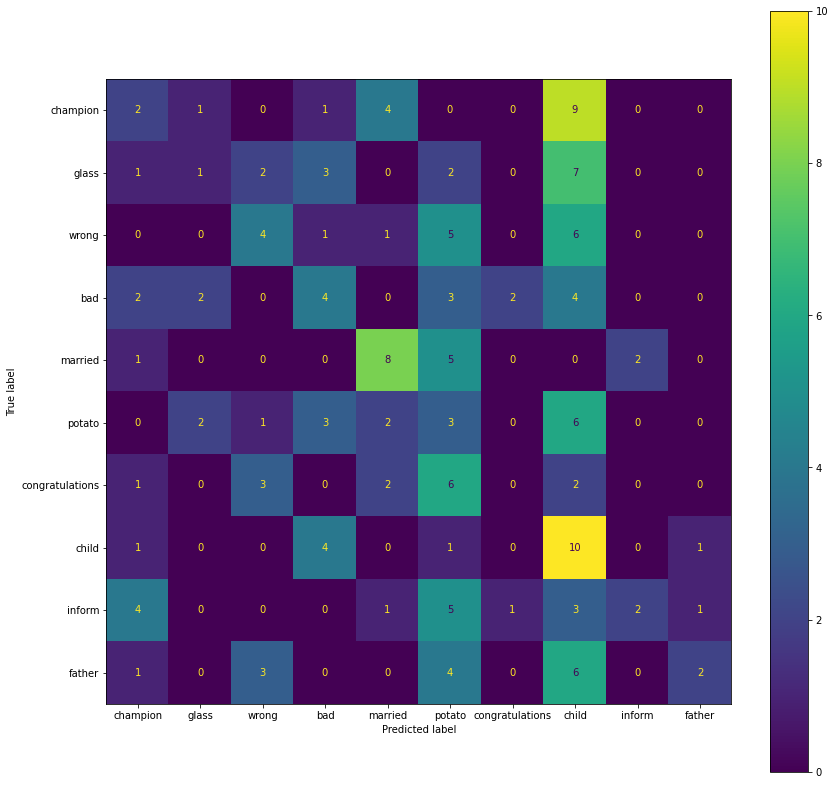

In [14]:
print(f'Total test data:{len(df)}')
cm = confusion_matrix(ground_truth_ids, predict_ids)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(target_names))
fig, ax = plt.subplots(figsize=(14,14))
disp.plot(ax=ax)